In [3]:
import tensorflow as tf
#from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.utils import normalize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Input,Conv3D , MaxPooling3D ,Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from PIL import Image
import cv2
import glob
import os

from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split, Dataset, ConcatDataset
import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2
import copy
from sklearn.model_selection import train_test_split

2024-06-30 17:52:20.548520: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-30 17:52:20.548639: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-30 17:52:20.684289: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
images_path = '/kaggle/input/suim-dataset/train_val(1)/train_val/images'
masks_path ='/kaggle/input/suim-dataset/train_val(1)/train_val/masks'

In [5]:
import os
images_paths = []
masks_paths = []

for imgname in os.listdir(images_path):
  images_paths.append(os.path.join(images_path,imgname))

for imgname in os.listdir(masks_path):
  masks_paths.append(os.path.join(masks_path,imgname))

In [6]:
images_paths.sort()
masks_paths.sort()

In [7]:
print(len(images_paths))


1525


In [8]:
SIZE_X = 128
SIZE_Y = 128

In [9]:
# def preprocess_image(image_path):
#     image = cv2.imread(image_path)

#     resized_image = cv2.resize(image, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
#     normalized_image = resized_image.astype(np.float32) / 255.0
#     return normalized_image



# preprocessed_images_data = []

# for imgpath in images_paths:

#         preprocessed_image = preprocess_image(imgpath)

#         preprocessed_images_data.append(preprocessed_image)
# X = np.array(preprocessed_images_data)

In [10]:
# SIZE_X = 224
# SIZE_Y = 224
# n_classes = 1

In [11]:
# import albumentations as A
# import cv2

# transform = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(p=0.2),
#     A.Rotate(limit=15, p=0.5),
#     A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
#     A.ElasticTransform(p=0.1)
# ])

# def augment_image_mask(image, mask):
#     augmented = transform(image=image, mask=mask)
#     return augmented['image'], augmented['mask']


# image = cv2.imread('path/to/image.png')
# mask = cv2.imread('path/to/mask.png', cv2.IMREAD_GRAYSCALE)

# aug_image, aug_mask = augment_image_mask(image, mask)


In [12]:
import cv2
import numpy as np
import albumentations as A
import cv2
preprocessed_masks_data = []
preprocessed_images_data = []
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5)
])
def preprocess_mask(imgpath , maskpath):

    image = cv2.imread(imgpath)
    mask = cv2.imread(maskpath)
    mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
    image = cv2.resize(image, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
    
    #print(np.unique(mask))
    augmented = transform(image=image, mask=mask)
    augment_mask = augmented['mask']
    augment_image = augmented['image']
    #print(np.unique(mask))
#     resized_mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
#     resized_mask=np.where(resized_mask > 70, 255,0)
#     normalized_mask = resized_mask.astype(np.float32) / 255.0
    
    #print(np.unique(augment_mask))
    image = image.astype(np.float32) / 255.0
    augment_image = augment_image.astype(np.float32) / 255.0
    mask=np.where(mask > 70, 255,0)
    mask = mask.astype(np.float32) / 255.0
    augment_mask=np.where(augment_mask > 70, 255,0)
    augment_mask = augment_mask.astype(np.float32) / 255.0
    return image , augment_image  , mask ,augment_mask
for  imgpath,maskpath in zip(images_paths,masks_paths):



        normalized_image , normalized_augment_image  , normalized_mask ,normalized_augment_mask = preprocess_mask(imgpath,maskpath)


        preprocessed_masks_data.append(normalized_mask)
        preprocessed_masks_data.append(normalized_augment_mask)
        preprocessed_images_data.append(normalized_image)
        preprocessed_images_data.append(normalized_augment_image)
        
X = np.array(preprocessed_images_data)
y = np.array(preprocessed_masks_data)


In [13]:
X.shape

(3050, 128, 128, 3)

In [14]:
np.unique(y)

array([0., 1.], dtype=float32)

In [15]:
a = np.array(preprocessed_masks_data[5])
np.unique(a)

array([0., 1.], dtype=float32)

In [16]:
v[0].shape

NameError: name 'v' is not defined

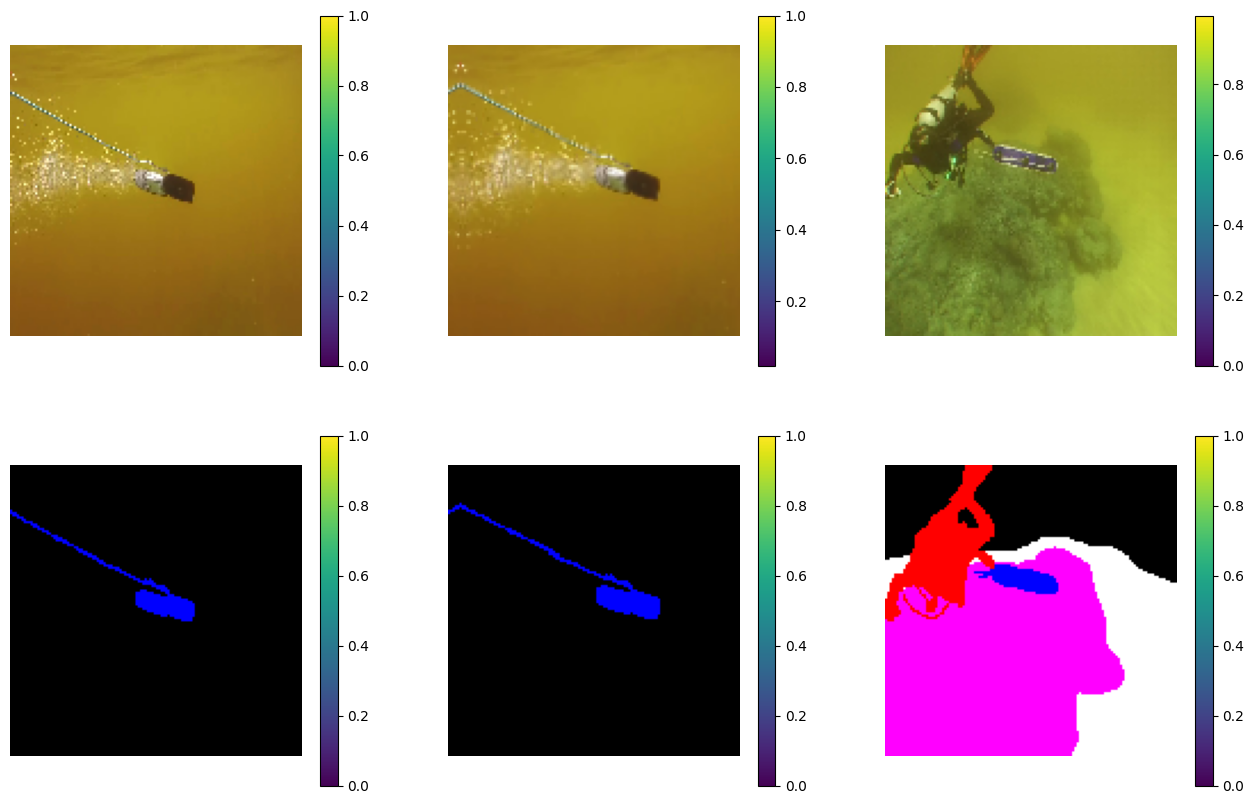

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10))
for i in range(1,4):
    plt.subplot(2,3,i)
    img = np.array(X[i+3])
#     print(img)
#     print(img.shape)
#     print(np.unique(img))
    plt.imshow(img)
    plt.colorbar()
    plt.axis('off')

for i in range(4,7):
    plt.subplot(2,3,i)
    img = np.squeeze(y[i])
    plt.imshow(img)
    plt.colorbar()
    plt.axis('off')
plt.show()

In [18]:
ini = 0 
one_hot_masks = []
for mask in y:
    ini += 1
    print(end=f"{ini}\r")
    height , width , _ = mask.shape
    one_hot_encoded = np.zeros((height, width, 8), dtype=np.uint8)
    for i in range(height):
        for j in range(width):
            r, g, b = mask[i, j]
            binary_index = int(r * 4 + g * 2 + b) 
            one_hot_encoded[i, j, binary_index] = 1
    one_hot_masks.append(one_hot_encoded)

In [19]:
one_hot_masks = np.array(one_hot_masks)

In [20]:
X_train , X_val , y_train , y_val = train_test_split(X, one_hot_masks, test_size=0.1, random_state=42)

In [ ]:
one_hot_masks.shape

In [ ]:
X.shape

In [ ]:
len(preprocessed_images_data[0][0][0])

In [18]:
X = np.array(preprocessed_images_data)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1525,) + inhomogeneous part.

In [ ]:
# class CustomDataset(Dataset):
#     def __init__(self, data, labels, transform = A.Compose([ToTensorV2()])):
#         self.data = data
#         self.labels = labels
#         self.transform = transform

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         mask_rgb = Image.fromarray(np.array(self.labels[idx]))
#         mask_gray = mask_rgb.convert('L')

        
#         image_np = np.array(self.data[idx])
#         mask_gray_np = np.array(mask_gray)

#         transformed = self.transform(image=image_np, mask=mask_gray_np)
        
#         return transformed['image'] / 255, transformed['mask'] / 255

In [ ]:
# class ZPool(nn.Module):
#     def __init__(self, kernel_size=2, stride=2):
#         super(ZPool, self).__init__()
#         self.kernel_size = kernel_size
#         self.stride = stride

#     def forward(self, x):
#         mean = F.avg_pool2d(x, self.kernel_size, self.stride, count_include_pad=False)
#         mean_sq = F.avg_pool2d(x * x, self.kernel_size, self.stride, count_include_pad=False)
#         std = (mean_sq - mean * mean).sqrt()
#         z = (x - mean) / (std + 1e-5)
#         z_pooled = F.max_pool2d(z, self.kernel_size, self.stride)
#         return z_pooled

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models

def conv_block(in_channels, out_channels):
    block = models.Sequential([
        layers.Conv2D(out_channels, kernel_size=3, padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2D(out_channels, kernel_size=3, padding='same'),
        layers.BatchNormalization(),
        layers.ReLU()
    ])
    return block

def encoder_block(in_channels, out_channels):
    inputs = layers.Input(shape=(None, None, in_channels))
    conv = conv_block(in_channels, out_channels)(inputs)
    pool = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    return models.Model(inputs=inputs, outputs=[conv, pool])

def decoder_block(in_channels, out_channels):
    inputs = layers.Input(shape=(None, None, in_channels))
    skip_inputs = layers.Input(shape=(None, None, out_channels))
    up = layers.Conv2DTranspose(out_channels, kernel_size=2, strides=2, padding='same')(inputs)
    skip_norm = layers.BatchNormalization()(skip_inputs)
    concat = layers.Concatenate(axis=-1)([up, skip_norm])
    conv = conv_block(out_channels * 2, out_channels)(concat)
    return models.Model(inputs=[inputs, skip_inputs], outputs=conv)

def unet(input_shape=(128, 128, 3), num_classes=8):
    inputs = layers.Input(shape=input_shape)
    
    enc1 = encoder_block(3, 64)
    enc2 = encoder_block(64, 128)
    enc3 = encoder_block(128, 256)
    enc4 = encoder_block(256, 512)
    
    s1, p1 = enc1(inputs)
    s2, p2 = enc2(p1)
    s3, p3 = enc3(p2)
    s4, p4 = enc4(p3)
    
    bottleneck = conv_block(512, 1024)(p4)
    
    dec4 = decoder_block(1024, 512)
    dec3 = decoder_block(512, 256)
    dec2 = decoder_block(256, 128)
    dec1 = decoder_block(128, 64)
    
    d4 = dec4([bottleneck, s4])
    d3 = dec3([d4, s3])
    d2 = dec2([d3, s2])
    d1 = dec1([d2, s1])
    
    out_conv = layers.Conv2D(num_classes, kernel_size=1)(d1)
    out_softmax = layers.Softmax(axis=-1)(out_conv)
    
    model = models.Model(inputs=inputs, outputs=out_softmax)
    return model


model = unet()
model.summary()


Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_2        │ [(None, 128, 128, │     39,232 │ input_layer[0][0] │
│ (Functional)        │ 64), (None, 64,   │            │                   │
│                     │ 64, 64)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_5        │ [(None, 64, 64,   │    222,464 │ functional_2[0][… │
│ (Functional)        │ 128), (None, 32,  │            │                   │
│                     │ 32, 128)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_8        │ [(None, 32, 32,   │    887,296 │ functional_5[0][… │
│ (Functional)        │ 256), (None, 16,  │            │                   │
│                     │ 16, 256)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_11       │ [(None, 16, 16,   │  3,544,064 │ functional_8[0][… │
│ (Functional)        │ 512), (None, 8,   │            │                   │
│                     │ 8, 512)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 8, 8,      │ 14,166,016 │ functional_11[0]… │
│ (Sequential)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_15       │ (None, 16, 16,    │  9,182,720 │ sequential_4[0][… │
│ (Functional)        │ 512)              │            │ functional_11[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_18       │ (None, 32, 32,    │  2,297,600 │ functional_15[0]… │
│ (Functional)        │ 256)              │            │ functional_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_21       │ (None, 64, 64,    │    575,360 │ functional_18[0]… │
│ (Functional)        │ 128)              │            │ functional_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_24       │ (None, 128, 128,  │    144,320 │ functional_21[0]… │
│ (Functional)        │ 64)               │            │ functional_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 128, 128,  │        520 │ functional_24[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Softmax)   │ (None, 128, 128,  │          0 │ conv2d_18[0][0]   │
│                     │ 8)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 31,059,592 (118.48 MB)

 Trainable params: 31,045,896 (118.43 MB)

 Non-trainable params: 13,696 (53.50 KB)

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
def iou_coef(y_true, y_pred, smooth=1):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2])
    union = K.sum(y_true, axis=[1, 2]) + K.sum(y_pred, axis=[1, 2]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def mean_iou(y_true, y_pred, num_classes):
    iou = []
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.one_hot(y_pred, num_classes)
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    for i in range(num_classes):
        iou.append(iou_coef(y_true[:, :, i], y_pred[:, :, i]))
    mean_iou = tf.reduce_mean(iou)
    return mean_iou

In [23]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy', lambda y_true, y_pred: mean_iou(y_true, y_pred, num_classes=8)])

In [24]:
history = model.fit(X_train ,
   y_train,
   epochs=20,
   validation_data= (X_val , y_val))

Epoch 1/20


I0000 00:00:1719770824.488431     143 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


86/86 ━━━━━━━━━━━━━━━━━━━━ 40s 466ms/step - accuracy: 0.6144 - lambda: 0.5588 - loss: 1.1460 - val_accuracy: 0.0444 - val_lambda: 0.0311 - val_loss: 132.0652
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 39s 451ms/step - accuracy: 0.6259 - lambda: 0.5680 - loss: 1.1002 - val_accuracy: 0.3098 - val_lambda: 0.3013 - val_loss: 13.8689
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 39s 456ms/step - accuracy: 0.6670 - lambda: 0.6174 - loss: 0.9738 - val_accuracy: 0.5290 - val_lambda: 0.5383 - val_loss: 1.4935
Epoch 7/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 39s 458ms/step - accuracy: 0.6926 - lambda: 0.6329 - loss: 0.8984 - val_accuracy: 0.6320 - val_lambda: 0.6019 - val_loss: 1.1025
Epoch 11/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 40s 460ms/step - accuracy: 0.6944 - lambda: 0.6350 - loss: 0.8815 - val_accuracy: 0.6649 - val_lambda: 0.6108 - val_loss: 0.9997
Epoch 12/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 40s 460ms/step - accuracy: 0.6926 - lambda: 0.6324 - loss: 0.8924 - val_accuracy: 0.6357 - val_lambda: 0.6148 - val_loss: 1.0903
Epoc

In [28]:
# def TA_encoder_block(in_channels, out_channels, use_triplet_attention=True):
#     inputs = layers.Input(shape=(None, None, in_channels))
#     conv = conv_block(in_channels, out_channels)(inputs)
    
#     if use_triplet_attention:
#         attn = triplet_attention(out_channels)(conv)
#     else:
#         attn = conv
    
#     pool = layers.MaxPooling2D(pool_size=(2, 2))(attn)
#     return models.Model(inputs=inputs, outputs=[attn, pool])

In [25]:
import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.layers import *

def conv_block(in_channels, out_channels):
   
    block = models.Sequential([
        layers.Conv2D(out_channels, kernel_size=3, padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2D(out_channels, kernel_size=3, padding='same'),
        layers.BatchNormalization(),
        layers.ReLU()
    ])
    return block

def decoder_block(in_channels, out_channels):
    
    inputs = layers.Input(shape=(None, None, in_channels))
    skip_inputs = layers.Input(shape=(None, None, out_channels))
    up = layers.Conv2DTranspose(out_channels, kernel_size=2, strides=2, padding='same')(inputs)
    skip_norm = layers.BatchNormalization()(skip_inputs)
    concat = layers.Concatenate(axis=-1)([up, skip_norm])
    conv = conv_block(out_channels * 2, out_channels)(concat)
    return models.Model(inputs=[inputs, skip_inputs], outputs=conv)

# def triplet_attention(channels):
   
#     def attention_module(x):
# #         def z_pool(x):
# #             max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=1, keepdims=True))(x)
# #             avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=1, keepdims=True))(x)
# #             z_pool_out = layers.Concatenate(axis=3)([max_pool, avg_pool])
# #             return z_pool_out

#         def conv_bn(x, out_channels):
#             x = layers.Conv2D(out_channels, kernel_size=3, padding='same')(x)
#             x = layers.BatchNormalization()(x)
#             return x

#         # Branch 1: Interactions between (C, H)
#         branch1 = layers.Permute((3, 2, 1))(x)
#         max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=1, keepdims=True))(x)
#         avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=1, keepdims=True))(x)
#         print(branch1.shape ,avg_pool.shape)
#         branch1  = layers.Concatenate(axis=1)([max_pool, avg_pool])
#         branch1 = conv_bn(branch1, channels)
#         branch1 = layers.Permute((2, 3, 1))(branch1)
#         branch1 = layers.Activation('sigmoid')(branch1)

#         # Branch 2: Interactions between (C, W)
#         branch2 = layers.Permute((3, 1, 2))(x)
#         max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=1, keepdims=True))(x)
#         avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=1, keepdims=True))(x)
#         print(branch2.shape, avg_pool.shape)
#         branch2  = layers.Concatenate(axis=1)([max_pool, avg_pool])
#         branch2 = conv_bn(branch2, channels)
#         branch2 = layers.Permute((2, 3, 1))(branch2)
#         branch2 = layers.Activation('sigmoid')(branch2)

#         # Branch 3: Interactions between (H, W)
        
#         max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(x)
#         avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(x)
#         print(x.shape , avg_pool.shape)
#         branch3  = layers.Concatenate(axis=-1)([max_pool, avg_pool])
#         branch3 = conv_bn(branch3, channels)
#         branch3 = layers.Activation('sigmoid')(branch3)

#         # Combining the branches
#         print(branch3.shape,branch2.shape,branch1.shape)
#         combined = layers.Add()([branch1, branch2, branch3])
#         combined = layers.Lambda(lambda x: x / 3)(combined)
#         return combined

#     return attention_module
class triplet_attention(Layer):
    def __init__(self, kernel_size=3, **kwargs):
        super(triplet_attention, self).__init__(**kwargs)
        self.kernel_size = kernel_size

    def build(self, input_shape):
        self.conv1 = Conv2D(filters=input_shape[-1], kernel_size=self.kernel_size, padding='same')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(filters=input_shape[-1], kernel_size=self.kernel_size, padding='same')
        self.bn2 = BatchNormalization()
        self.conv3 = Conv2D(filters=input_shape[-1], kernel_size=self.kernel_size, padding='same')
        self.bn3 = BatchNormalization()

    def call(self, inputs):

       
        x1 = tf.transpose(inputs, [0, 3, 1, 2])
        x1_max = tf.reduce_max(x1, axis=1, keepdims=True)
        x1_mean = tf.reduce_mean(x1, axis=1, keepdims=True)
        x1 = tf.concat([x1_max, x1_mean], axis=1)
        x1 = tf.transpose(x1, [0, 2, 3, 1])
        x1 = self.conv1(x1)
        x1 = self.bn1(x1)
        x1 = Activation('sigmoid')(x1)

       
        x2 = tf.transpose(inputs, [0, 3, 2, 1])
        x2_max = tf.reduce_max(x2, axis=1, keepdims=True)
        x2_mean = tf.reduce_mean(x2, axis=1, keepdims=True)
        x2 = tf.concat([x2_max, x2_mean], axis=1)
        x2 = tf.transpose(x2, [0, 2, 3, 1])
        x2 = self.conv2(x2)
        x2 = self.bn2(x2)
        x2 = Activation('sigmoid')(x2)

   
        x3_max = tf.reduce_max(inputs, axis=-1, keepdims=True)
        x3_mean = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        x3 = tf.concat([x3_max, x3_mean], axis=-1)
        x3 = self.conv3(x3)
        x3 = self.bn3(x3)
        x3 = Activation('sigmoid')(x3)

        
        out = (inputs * x1 + inputs * x2 + inputs * x3) / 3
        return out
def TA_encoder_block(in_channels, out_channels, use_triplet_attention=True):
   
    inputs = layers.Input(shape=(None, None, in_channels))
    conv = conv_block(in_channels, out_channels)(inputs)
    
    if use_triplet_attention:
        attn = triplet_attention()(conv)
    else:
        attn = conv
    
    pool = layers.MaxPooling2D(pool_size=(2, 2))(attn)
    return models.Model(inputs=inputs, outputs=[attn, pool])

def TA_Unet(input_shape=(128, 128, 3), num_classes=8):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    enc1 = TA_encoder_block(3, 64, use_triplet_attention=False)
    enc2 = TA_encoder_block(64, 128)
    enc3 = TA_encoder_block(128, 256)
    enc4 = TA_encoder_block(256, 512)
    
    s1, p1 = enc1(inputs)
    print(f"s1 shape: {s1.shape}, p1 shape: {p1.shape}")
    s2, p2 = enc2(p1)
    print(f"s2 shape: {s2.shape}, p2 shape: {p2.shape}")
    s3, p3 = enc3(p2)
    print(f"s3 shape: {s3.shape}, p3 shape: {p3.shape}")
    s4, p4 = enc4(p3)
    print(f"s4 shape: {s4.shape}, p4 shape: {p4.shape}")
    
    # Bottleneck
    bottleneck = conv_block(512, 1024)(p4)
    print(f"bottleneck shape: {bottleneck.shape}")
    
    # Decoder
    dec4 = decoder_block(1024, 512)
    dec3 = decoder_block(512, 256)
    dec2 = decoder_block(256, 128)
    dec1 = decoder_block(128, 64)
    
    d4 = dec4([bottleneck, s4])
    print(f"d4 shape: {d4.shape}")
    d3 = dec3([d4, s3])
    print(f"d3 shape: {d3.shape}")
    d2 = dec2([d3, s2])
    print(f"d2 shape: {d2.shape}")
    d1 = dec1([d2, s1])
    print(f"d1 shape: {d1.shape}")
    
    # Output layer
    out_conv = layers.Conv2D(num_classes, kernel_size=1)(d1)
    out_softmax = layers.Softmax(axis=-1)(out_conv)
    
    model = models.Model(inputs=inputs, outputs=out_softmax)
    return model

model1 = TA_Unet()
model1.summary()


s1 shape: (None, 128, 128, 64), p1 shape: (None, 64, 64, 64)
s2 shape: (None, 64, 64, 128), p2 shape: (None, 32, 32, 128)
s3 shape: (None, 32, 32, 256), p3 shape: (None, 16, 16, 256)
s4 shape: (None, 16, 16, 512), p4 shape: (None, 8, 8, 512)
bottleneck shape: (None, 8, 8, 1024)
d4 shape: (None, 16, 16, 512)
d3 shape: (None, 32, 32, 256)
d2 shape: (None, 64, 64, 128)
d1 shape: (None, 128, 128, 64)


Model: "functional_53"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_29       │ [(None, 128, 128, │     39,232 │ input_layer_22[0… │
│ (Functional)        │ 64), (None, 64,   │            │                   │
│                     │ 64, 64)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_32       │ [(None, 64, 64,   │    231,296 │ functional_29[0]… │
│ (Functional)        │ 128), (None, 32,  │            │                   │
│                     │ 32, 128)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_35       │ [(None, 32, 32,   │    904,960 │ functional_32[0]… │
│ (Functional)        │ 256), (None, 16,  │            │                   │
│                     │ 16, 256)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_38       │ [(None, 16, 16,   │  3,579,392 │ functional_35[0]… │
│ (Functional)        │ 512), (None, 8,   │            │                   │
│                     │ 8, 512)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_13       │ (None, 8, 8,      │ 14,166,016 │ functional_38[0]… │
│ (Sequential)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_42       │ (None, 16, 16,    │  9,182,720 │ sequential_13[0]… │
│ (Functional)        │ 512)              │            │ functional_38[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_45       │ (None, 32, 32,    │  2,297,600 │ functional_42[0]… │
│ (Functional)        │ 256)              │            │ functional_35[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_48       │ (None, 64, 64,    │    575,360 │ functional_45[0]… │
│ (Functional)        │ 128)              │            │ functional_32[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_51       │ (None, 128, 128,  │    144,320 │ functional_48[0]… │
│ (Functional)        │ 64)               │            │ functional_29[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 128, 128,  │        520 │ functional_51[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_1 (Softmax) │ (None, 128, 128,  │          0 │ conv2d_46[0][0]   │
│                     │ 8)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 31,121,416 (118.72 MB)

 Trainable params: 31,102,344 (118.65 MB)

 Non-trainable params: 19,072 (74.50 KB)

In [26]:
model1.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy', lambda y_true, y_pred: mean_iou(y_true, y_pred, num_classes=8)])

In [27]:
history1 = model1.fit(X_train ,
   y_train,
   epochs=20,
   validation_data= (X_val , y_val))

Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 101s 783ms/step - accuracy: 0.5324 - lambda: 0.4744 - loss: 1.4389 - val_accuracy: 0.1129 - val_lambda: 0.0741 - val_loss: 10.2812
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 44s 513ms/step - accuracy: 0.6014 - lambda: 0.5509 - loss: 1.1836 - val_accuracy: 0.1746 - val_lambda: 0.1837 - val_loss: 5.3467
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 43s 502ms/step - accuracy: 0.6297 - lambda: 0.5798 - loss: 1.0894 - val_accuracy: 0.2096 - val_lambda: 0.2830 - val_loss: 4.0912
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 44s 507ms/step - accuracy: 0.6439 - lambda: 0.5943 - loss: 1.0406 - val_accuracy: 0.3456 - val_lambda: 0.3314 - val_loss: 3.0604
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 43s 505ms/step - accuracy: 0.6490 - lambda: 0.5836 - loss: 1.0197 - val_accuracy: 0.4185 - val_lambda: 0.4170 - val_loss: 1.9189
Epoch 6/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 43s 505ms/step - accuracy: 0.6605 - lambda: 0.6003 - loss: 0.9854 - val_accuracy: 0.5193 - val_lambda: 0.5194 - val_loss: 1.8

In [31]:
def plot_loss_miou(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['lambda']
    val_acc = history.history['val_lambda']
    
    epochs = range(1, len(train_loss) + 1)
    
    fig, axs = plt.subplots(2, figsize=(10, 7))
    fig.suptitle('Training and Validation Metrics')
    
    # Loss plot
    axs[0].plot(epochs, train_loss, label='Training loss', c='red')
    axs[0].plot(epochs, val_loss, label='Validation loss', c='blue')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].set_ylim([0, 1.5])
    
    # Accuracy plot
    axs[1].plot(epochs, train_acc, label='Training mIoU', c='red')
    axs[1].plot(epochs, val_acc, label='Validation mIoU', c='blue')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('mIoU')
    axs[1].legend()
    
    plt.subplots_adjust(hspace=0.5)
    plt.show()

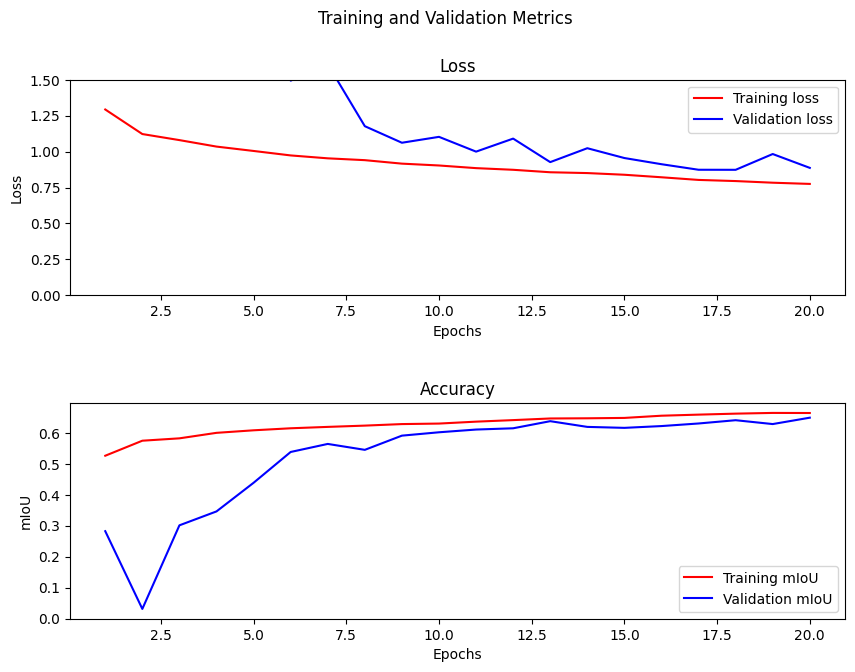

In [32]:
plot_loss_miou(history)

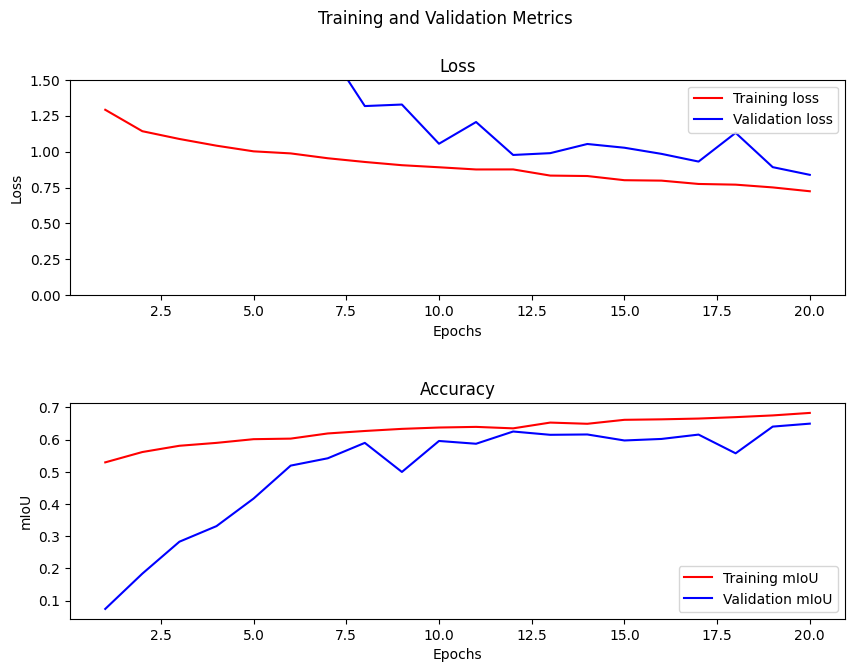

In [33]:
plot_loss_miou(history1)

In [35]:
images_path_test = '/kaggle/input/suim-dataset/TEST(2)/TEST/images'
masks_path_test ='/kaggle/input/suim-dataset/TEST(2)/TEST/masks'

In [50]:
import os
images_paths_test = []
masks_paths_test = []

for imgname in os.listdir(images_path_test):
    if imgname.endswith('.jpg'):
          images_paths_test.append(os.path.join(images_path_test,imgname))

for imgname in os.listdir(masks_path_test):
    if imgname.endswith('.bmp'):
          masks_paths_test.append(os.path.join(masks_path_test,imgname))
  

In [53]:
def preprocess_mask_2(imgpath , maskpath):

    image = cv2.imread(imgpath)
    mask = cv2.imread(maskpath)
    image = cv2.resize(image, (128, 128), interpolation = cv2.INTER_NEAREST)
    mask = cv2.resize(mask, (128, 128), interpolation = cv2.INTER_NEAREST)
    
    image = image.astype(np.float32) / 255.0
    mask=np.where(mask > 70, 255,0)
    mask = mask.astype(np.float32) / 255.0
    return image , mask

In [60]:
preprocessed_masks_test_data = []
preprocessed_images_test_data = []
for  imgpath,maskpath in zip(images_paths_test,masks_paths_test):
      


        normalized_image ,normalized_mask  = preprocess_mask_2(imgpath,maskpath)


        preprocessed_masks_test_data.append(normalized_mask)
        preprocessed_images_test_data.append(normalized_image)

        
X_test = np.array(preprocessed_images_test_data)
y_test = np.array(preprocessed_masks_test_data)

In [62]:
ini = 0 
one_hot_masks = []
for mask in y_test:
    ini += 1
    print(end=f"{ini}\r")
    height , width , _ = mask.shape
    one_hot_encoded = np.zeros((height, width, 8), dtype=np.uint8)
    for i in range(height):
        for j in range(width):
            r, g, b = mask[i, j]
            binary_index = int(r * 4 + g * 2 + b) 
            one_hot_encoded[i, j, binary_index] = 1
    one_hot_masks.append(one_hot_encoded)

In [65]:
y_testt = np.array(one_hot_masks)

In [70]:
y_pred =model.predict(X_test)

mean_iou(y_testt, y_pred, num_classes=8)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step
<tf.Tensor: shape=(), dtype=float32, numpy=0.56899838>


In [71]:
y_pred =model1.predict(X_test)

mean_iou(y_testt, y_pred, num_classes=8)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step
<tf.Tensor: shape=(), dtype=float32, numpy=0.58436285>
